In [1]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import random
import collections
from PIL import Image

In [2]:
def prepDE(img):
    
    show = img[: , : , : : -1]
    width = img.shape[1]
    height = img.shape[0]
    
    # Normalize
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    
    # Guided Filter
    guide = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (np.median(img.shape) > 200):
        dst = cv2.ximgproc.guidedFilter(guide=guide, src=img, radius=21, eps = int(np.max(img.shape)), dDepth=-1)
        element = cv2.getStructuringElement(cv2.MORPH_RECT,(11, 11))
    else:
        dst = cv2.ximgproc.guidedFilter(guide=guide, src=img, radius=9, eps = int(np.max(img.shape)), dDepth=-1)
        element = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7))
    
    # Dilating and Eroding
    dilate = cv2.dilate(dst, element)
    erode = cv2.erode(dst, element)
    result = cv2.absdiff(dilate,erode)

    # Edge Detection
    edge = cv2.Canny(result, 50, 200)
    
    return (show, edge)

In [3]:
def prepCO(img):
    
    show = img[: , : , : : -1]
    width = img.shape[1]
    height = img.shape[0]
    
    # Normalize
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    
    # Guided Filter
    guide = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (np.median(img.shape) > 200):
        dst = cv2.ximgproc.guidedFilter(guide=guide, src=img, radius=21, eps = int(np.max(img.shape)), dDepth=-1)
    else:
        dst = cv2.ximgproc.guidedFilter(guide=guide, src=img, radius=9, eps = int(np.max(img.shape)), dDepth=-1)
    
    # Convert it into grey-level image
    img_gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    
    # Convert it into binary image
    ret, img_B = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    img_B = img_gray

    # Closing and Openning
    o3 = cv2.morphologyEx(cv2.morphologyEx(img_B, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    o5 = cv2.morphologyEx(cv2.morphologyEx(img_B, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    o7 = cv2.morphologyEx(cv2.morphologyEx(img_B, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((7,7), np.uint8))
    o9 = cv2.morphologyEx(cv2.morphologyEx(img_B, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((9,9), np.uint8))
    o11 = cv2.morphologyEx(cv2.morphologyEx(img_B, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8)), 
                           cv2.MORPH_OPEN, np.ones((11,11), np.uint8))

    opening = np.uint8((np.array(o3) + np.array(o5) + np.array(o7) + np.array(o9) + np.array(o11))/5) if np.median(img.shape) > 200 else img_B

    # Edge Detection
    edge = cv2.Canny(opening, 50, 200)
    
    return (show, edge)

In [4]:
def prepNew(img):
    
    show = img[: , : , : : -1]
    width = img.shape[1]
    height = img.shape[0]
    
    # Normalize
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    
    # Convert it into grey-level image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Guided Filtering
    guided = cv2.ximgproc.guidedFilter(guide=gray, src=img, radius=21, eps = int(np.max(img.shape)), dDepth=-1)
    gg = cv2.cvtColor(guided, cv2.COLOR_RGB2GRAY)
    
    a = int(np.percentile(gg, 25))
    b = int(np.percentile(gg, 75))
    c = int(np.percentile(gg, 50))

    gg_new = gg.reshape(gg.shape[0]*gg.shape[1])

    A = gg.min()
    B = gg.max()
    
    for i in range(gg_new.shape[0]):
        if gg_new[i] > b:
            gg_new[i] = int((255 - 64) + 64 * (gg_new[i] - b)/(B - b))
        elif gg_new[i] < a:
            gg_new[i] = int(64 * (gg_new[i] - A)/(a - A))
        else:
            gg_new[i] = int(64 + (190 - 64 + 1) * (gg_new[i] - a)/(b-a))
        
    gg = gg_new.reshape(gg.shape[0], gg.shape[1])
    
    info = np.array([A, a, c, b, B])
    
    return (show, gg, info)

In [5]:
IMG = list()
EDGE = list()
OUT = list()

for i in range(47):
    img = cv2.imread(str(i) + ".jpg")
    (img, edge) = prepCO(img)
    edge_show = np.expand_dims(edge, axis=2)
    edge_show = np.concatenate((edge_show, edge_show, edge_show), axis=-1)
    out = np.concatenate((img, edge_show), axis = 1)
    IMG.append(img)
    EDGE.append(edge)
    OUT.append(out)
    im = Image.fromarray(out)
    im.save('./out/C&O/' + str(i) + '.png')

In [6]:
IMG = list()
EDGE = list()
OUT = list()

for i in range(47):
    img = cv2.imread(str(i) + ".jpg")
    (img, edge) = prepDE(img)
    edge_show = np.expand_dims(edge, axis=2)
    edge_show = np.concatenate((edge_show, edge_show, edge_show), axis=-1)
    out = np.concatenate((img, edge_show), axis = 1)
    IMG.append(img)
    EDGE.append(edge)
    OUT.append(out)
    im = Image.fromarray(out)
    im.save('./out/E&D/' + str(i) + '.png')

In [7]:
IMG = list()
EDGE = list()
OUT = list()
INFO = list()

for i in range(47):
    img = cv2.imread(str(i) + ".jpg")
    (img, edge, info) = prepNew(img)
    INFO.append(info)
    edge_show = np.expand_dims(edge, axis=2)
    edge_show = np.concatenate((edge_show, edge_show, edge_show), axis=-1)
    out = np.concatenate((img, edge_show), axis = 1)
    IMG.append(img)
    EDGE.append(edge)
    OUT.append(out)
    im = Image.fromarray(out)
    im.save('./out/New/' + str(i) + '.png')

In [8]:
df = pd.DataFrame(np.array(INFO).T, index = ['MIN', 'Q1', 'MEDIAN', 'Q3', 'MAX'])
df

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
MIN,8,8,7,4,5,4,6,9,10,7,...,0,3,4,46,31,17,13,16,35,81
Q1,99,156,159,81,55,91,85,70,103,115,...,84,86,53,135,130,65,76,110,154,169
MEDIAN,252,161,182,123,123,126,145,82,127,145,...,101,109,67,162,152,143,161,158,168,182
Q3,255,174,195,171,184,158,164,94,147,162,...,129,129,100,189,179,160,201,180,183,193
MAX,255,234,249,221,239,249,248,237,240,249,...,255,246,255,225,236,238,240,247,233,213


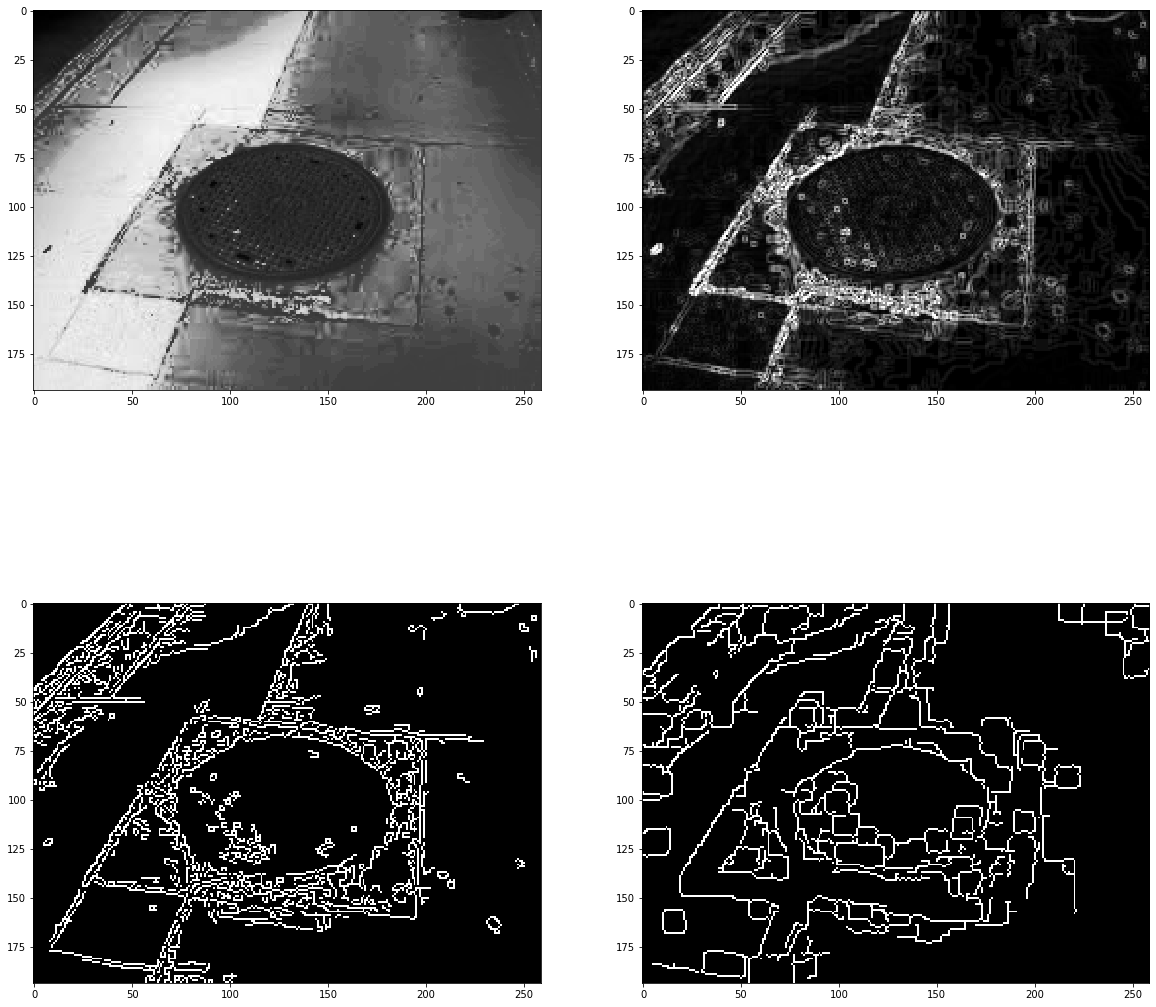

In [144]:
fig = plt.figure(figsize=(20,20))

img = EDGE[1]

ax = plt.subplot(221)
plt.imshow(img, 'gray')

ax = plt.subplot(222)

o3 = cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
o5 = cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
o7 = cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8)), 
                          cv2.MORPH_OPEN, np.ones((7,7), np.uint8))

opening = np.uint8((np.array(o3) + np.array(o5) + np.array(o7))/3) if np.median(img.shape) > 200 else img

gg = img

x = cv2.Sobel(img,cv2.CV_16S,1,0)
y = cv2.Sobel(img,cv2.CV_16S,0,1)
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
dst = cv2.addWeighted(absX,0.5,absY,0.5,0)

plt.imshow(dst, 'gray')

ax = plt.subplot(223)
a = int(np.percentile(gg, 25))
b = int(np.percentile(gg, 75))
edge = cv2.Canny(gg, a, b)
plt.imshow(edge, 'gray')

ax = plt.subplot(224)
element = cv2.getStructuringElement(cv2.MORPH_RECT,(11, 11))
dilate = cv2.dilate(gg, element)
erode = cv2.erode(gg, element)
result = cv2.absdiff(dilate,erode)
edge = cv2.Canny(result, 63,192)
plt.imshow(edge, 'gray')
